# Panorama Image Stitching
In this assignment, you will generate a stitched panorama image from multiple input images.

## Submission Details
Assignment deadline: Midnight, Tuesday 7th March \
Jupyter Notebook containing submission to be submitted via blackboard \
Total grade: 10% of final module mark 

# Submission details:
#### Name: Smitesh Patil
#### ID: 222233696
#### Class code: 1CSD1

In [1]:
# Load required Libraries
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os

## Read in the images

Note that there will be multiple image sets to try in this assignment. For full marks, you will need to report the results of your solution on each of the sets of images

In [2]:
# read image
path = 'images'
input_path = path + '/set_1/'
filenames = [input_path + filename for filename in os.listdir(input_path)]
filenames = filenames
raw_images = [cv2.imread(filename) for filename in filenames]
count = len(raw_images)

## Reorder the images
As this assignment will require the merge of multiple images, we need to do some alignment of the images. THe idea is to reset the order of the images, and to make the centre image the "source" image, and to then extend the panorama to both sides. \

As this is not the key learning from this assignment, the code is provided, no modifications are required

In [3]:
# reset the order of the images to make the center one is the source image, and extend to both sides
images = []
new_idx = (count - 1) // 2
k = -1
for i in range(count):
    new_idx = new_idx + k * i
    images.append(raw_images[new_idx])
    k *= -1

# initialize the source image
img_src = images[0]

## Perform panorama stitching

In this section, implement the panorama image stitching. Note that there are multiple approaches that will work to achieve this, and you can find multiple examples online. In this assignment, we will work through one possible implementation. 

Note that in this example, the goal is to merge multiple images (many demos online only merge two images). Also, for this example, we will consider horizontal merges only. It is relatively straight forward to extend this implementation to consider vertical panorama stitching too.

Note: with this implementation, the quality varies with the number of input images (merging 2 images is ok, but for more than 2, the perspective isn't very good). So try varying the number of images used in the merge

In [4]:
# the image need to stitch
def image_stiching(images, img_src):
    for i in range(1, len(images)):
        img_dst = images[i]
        # make sure to merge from left to right
        if i % 2 == 0:
            img_src, img_dst = img_dst, img_src

        # detects keypoints and computes the descriptors for "source" and "destination" images (hint: use ORB features)    
        orb = cv2.ORB_create()
        kp1, des1 = orb.detectAndCompute(img_src,None)
        kp2, des2 = orb.detectAndCompute(img_dst,None)

        # create a brute foce matching function, and calculate the matches
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = matcher.match(des1, des2)


        # sort the matches by distance
        # Keep only the top 50 matches
        matches = sorted(matches, key=lambda x: x.distance)[:50]

        # Get the keypoints from the matches
        src_pts = np.zeros((len(matches), 2), dtype=np.float32).reshape(-1, 1, 2)
        dst_pts = np.zeros((len(matches), 2), dtype=np.float32).reshape(-1, 1, 2)
        for i, match in enumerate(matches):
            src_pts[i, :] = kp1[match.queryIdx].pt
            dst_pts[i, :] = kp2[match.trainIdx].pt

        # Compute the homography matrix using RANSAC
        H , mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC)

        # show the keypoint matches (hint: use the opencv drawMatches function)
        img3 = cv2.drawMatches(img_src, kp1, img_dst, kp2, matches, None)
        plt.figure(figsize=(20,20))
        plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
        plt.show()

        # show matched points image


        # get the height and width of the original images
        h1, w1, p1 = img_src.shape
        h2, w2, p2 = img_dst.shape
        h = np.maximum(h1, h2)
        w = np.maximum(w1, w2)

        move_dis = int(np.maximum(dst_pts[0][0][0], src_pts[0][0][0]))

        # apply perspective correction (hint: use opencv warpPerspective. Set the width and height to (w1 + w2 - move_dis, h))
        warped = cv2.warpPerspective(img_dst, H, (w1 + w2 - move_dis, h))

        # combine the source image to the transformed image
        img_transform = warped.copy()
        img_transform[0:img_src.shape[0], 0:img_src.shape[1]] = img_src

        r_crop = w + move_dis

        img_transform = img_transform[:, :r_crop]
        # use img_transform as the source image for the next iteration of the loop
        img_src = img_transform
    return img_src

<Figure size 1440x1440 with 0 Axes>

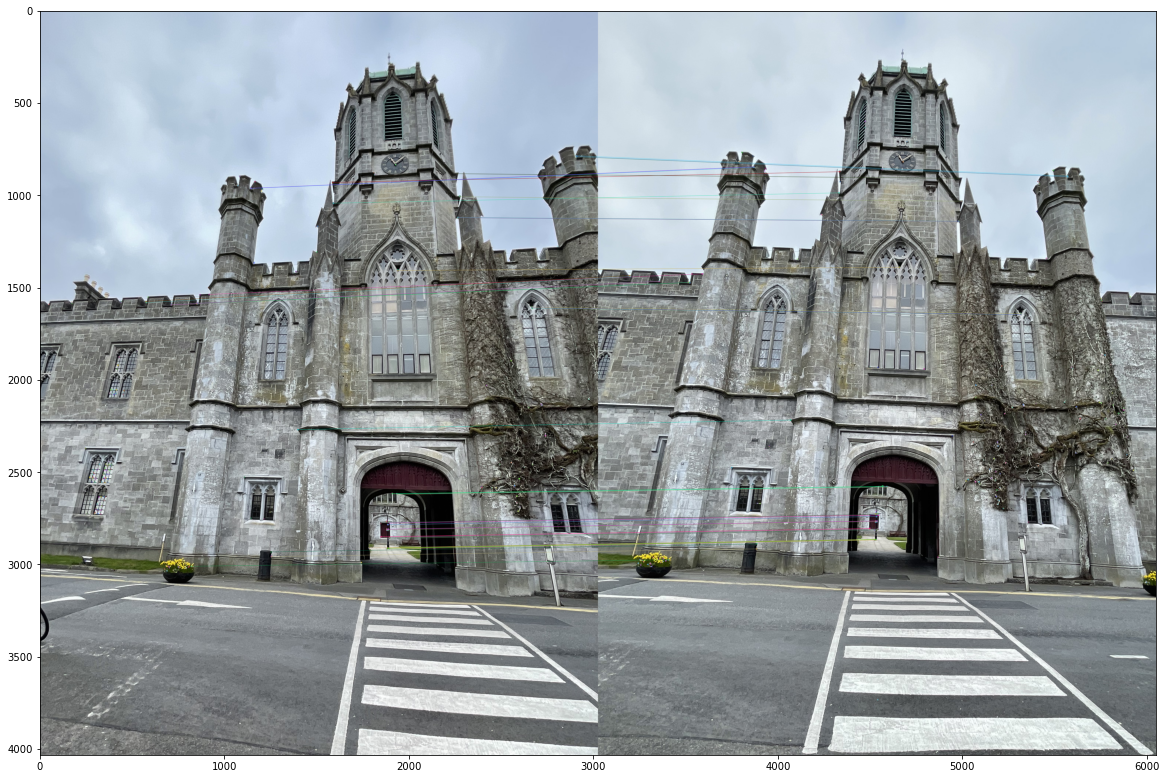

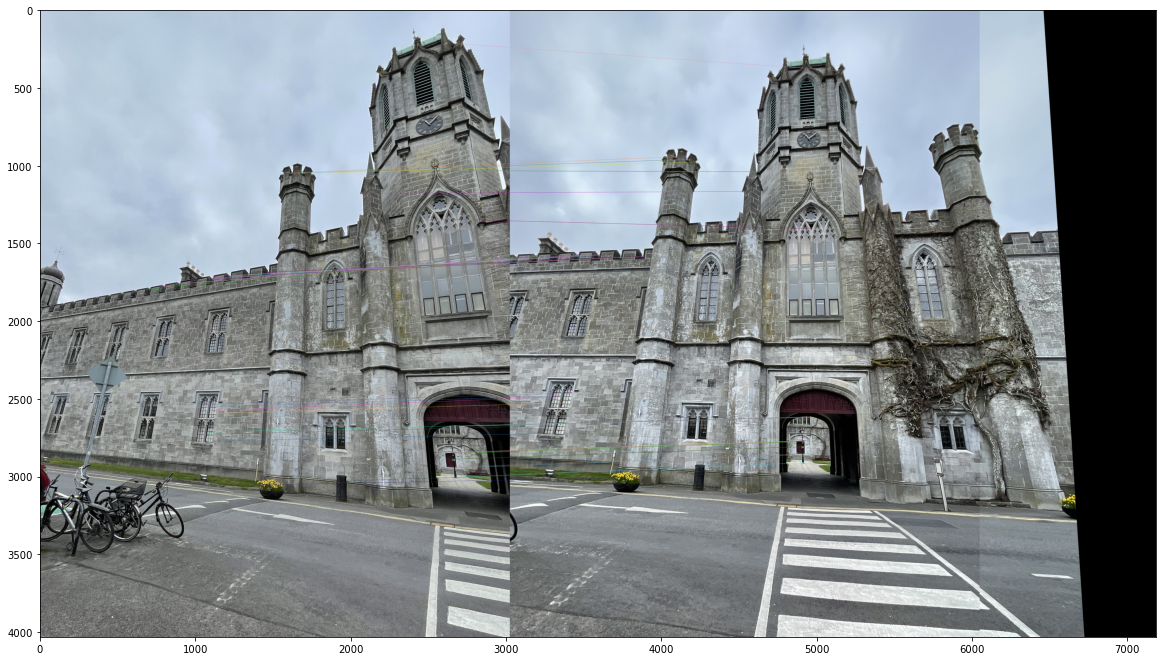

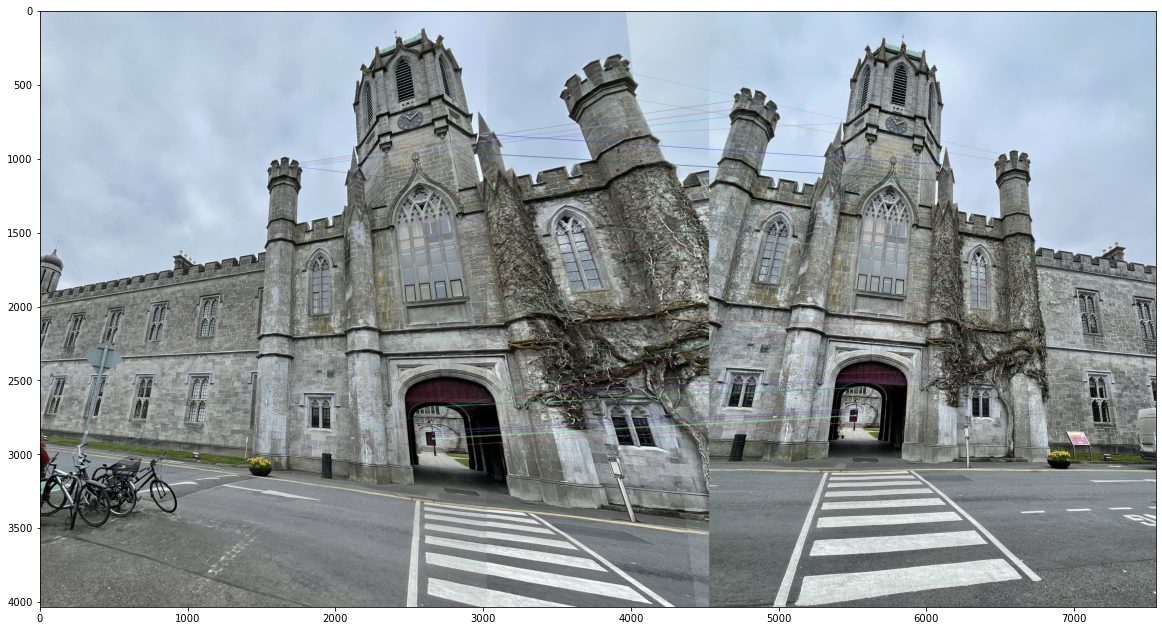

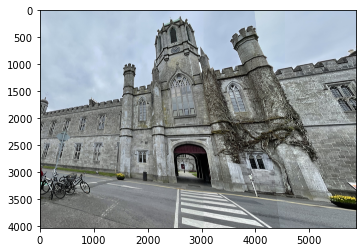

In [6]:
plt.figure(figsize = (20,20))
plt.imshow(cv2.cvtColor(image_stiching(images, img_src), cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# Display final panorama

def read_images_in_order(path):
    filenames = [path + filename for filename in os.listdir(path)]
    filenames = filenames
    raw_images = [cv2.imread(filename) for filename in filenames]
    count = len(raw_images)
    images = []
    new_idx = (count - 1) // 2
    k = -1
    for i in range(count):
        new_idx = new_idx + k * i
        images.append(raw_images[new_idx])
        k *= -1
    return images

panaroma_images = []

for i in range(0, 5):
    path = 'images/set_' + str(i+1)+ '/'
    images = read_images_in_order(path)
    
    # initialize the source image
    img_src = images[0]
    print("Matches drawn for set", (i+1))
    img = image_stiching(images, img_src)
    
    print("Panaroma for set ", (i+1))
    panaroma_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    f = plt.figure(figsize=(20, 20))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

## Summary of findings
At this stage, you should have tried your implementation on all of the image sets provided.\
You should have noticed by now that:
- One of the sets does not give a good result (and a lot of artifacts with the "out of the box" solution
- In some cases, even when there is a relatively good stitch, the final panorama perspective isn't very good
- A black boarder is visible in the image
- There are some mismatches in image brightness
- there are sharp transitions between merged images

For all of the points above, suggest 
- A reason for the issue
- A potential fix for the issue

### Answers:

###### 1. One of the sets does not give a good result (and a lot of artifacts with the "out of the box" solution

Answer: This happend because while stiching the images together the images should have overlap amongst themselves for a better panorama, in the case of set 3 of that quality of images is misising.

Solution : Images should have more portions overlapping, so that the stiching alogrithm can find matches for merging the final panorama

###### 2. In some cases, even when there is a relatively good stitch, the final panorama perspective isn't very good

Answer: 

###### 3. A black boarder is visible in the image

Answer: It is because of cropping of the images as the final stiched imaged is formed on basis of sample overlapping images they  are cropped by out stiching alogrithm these may result in black areas around the image where  the images don't align

Solution : We can find the countours of the black pixels in the image and omit the largest one from the final image

###### 4. There are some mismatches in image brightness

Answer: If there are variations in exposure or different lighting conditions while capturing the images it will cause patches of uneven brightness in the final image, eg in the final image of set 2.

Solutions: It is important to ensure that the lighting conditions are constant across all images considered to create the panorama

###### 5. there are sharp transitions between merged images
Answer: If the images used to create panorama were not aligned correctly, it will cause problem of sharp transitions present in the images

Solution: to avoid the problem it is necessary to make sure that images are aligned properly and there are overlapping points among the images.

## Extra credit

For a 2 mark extra credit assignment, implement a fix for __One__ of the following:
- A solution to correct the perspective in when more than 2 images are merged
- Remove the black pixels and crop the minimum "complete" area from the panorama (with an intelligent solution, not a manual hack!!!)
- Smooth the transitions between merges and minimize the brightness differences

In [ ]:
import cv2

for i in range(0, 5):
    # Load the panorama image
    panorama = panaroma_images[i]

    # Convert the image to grayscale
    gray = cv2.cvtColor(panorama, cv2.COLOR_BGR2GRAY)

    # Apply binary threshold to separate black pixels
    ret, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    # Find contours of black pixels
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find bounding box of largest contour
    max_area = 0
    largest_contour = None
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            largest_contour = contour

    x, y, w, h = cv2.boundingRect(largest_contour)

    # Crop the image
    panorama = panorama[y:y+h, x:x+w]

    # Apply binary threshold to separate non-black pixels
    gray = cv2.cvtColor(panorama, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    # Find contours of non-black pixels
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find bounding box of largest contour
    max_area = 0
    largest_contour = None
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            largest_contour = contour

    x, y, w, h = cv2.boundingRect(largest_contour)

    # Crop the image again
    panorama = panorama[y:y+h, x:x+w]

    fig, axs = plt.subplots(1, 2, figsize=(20,20))
    fig.suptitle('Orignal Image v black counters removed ')
    axs[0].imshow(panaroma_images[i])
    axs[1].imshow(panorama)
